# The following code implements Algorithm 12 MeasureBias Page 185 of Gerald Friedland: "Information-Driven Machine Learning", Springer-Nature, 2023.

## https://link.springer.com/book/10.1007/978-3-031-39477-5

### The code is written by Neil Patel and released into public domain for demonstration purposes only, use at your own risk.  I appreciate a citation of this repository or the book, whatever fits best.

### Measuring the bias of a given trained model. The algorithm creates an evaluation table by generating random numbers in the min and max range of the column's original values. It then creates predictions for the evaluation table and plots a histogram for the distribution of predictions. A bias-free model would have a completely flat output histogram. Any bias toward or against a certain class is indicated as a higher or lower than average bar in the histogram

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [16]:
# Load the Iris dataset from CSV
iris = pd.read_csv('iris.csv')
X = iris.iloc[:, :-1].values
y = iris.iloc[:, -1].values


In [17]:
# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [18]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [20]:
# Define the model
class IrisClassifier(nn.Module):
    def __init__(self):
        super(IrisClassifier, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = IrisClassifier()

In [21]:
# Train the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

In [22]:
# Evaluate the model
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)
    accuracy = (predicted == y_test).sum().item() / y_test.size(0)
    print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.53


In [23]:
# Implement the bias measurement algorithm
def measure_bias(model, X, y):
    eval_table = []

    for i in range(X.shape[1]):
        min_val = X[:, i].min()
        max_val = X[:, i].max()
        eval_table.append(np.random.uniform(min_val, max_val, size=len(X)))

    eval_table = torch.tensor(np.array(eval_table).T, dtype=torch.float32)
    predictions = model(eval_table)
    _, predicted = torch.max(predictions.data, 1)

    plt.figure(figsize=(8, 6))
    plt.hist(predicted.numpy(), bins=len(set(y)), edgecolor='black')
    plt.title('Prediction Distribution')
    plt.xlabel('Predicted Class')
    plt.ylabel('Count')
    plt.show()


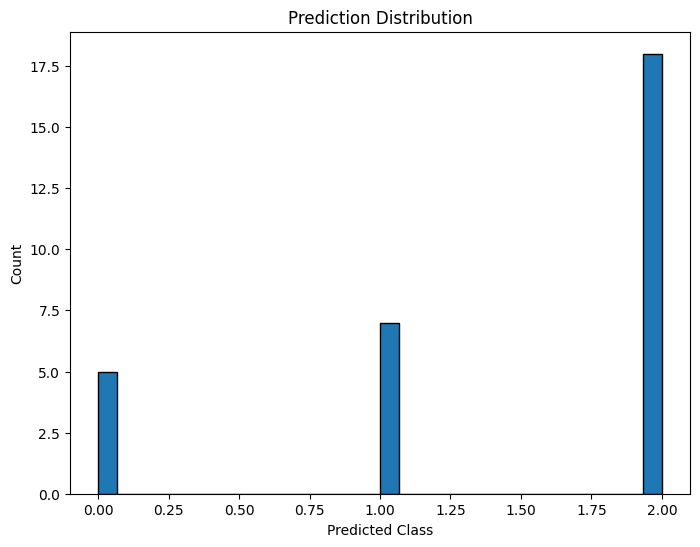

In [24]:
# Apply the bias measurement algorithm to the trained Iris model
measure_bias(model, X_test, y_test)